In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
import shap
import lime.lime_tabular


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3a2716e309d611f019adc6611efc16e5787eebecb41627ee7700636bdc49bbb9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [5]:
df = pd.read_csv('/content/S1File.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (200, 93)


,id,K1,K2,K3,K4,K5,K6,K7,K8,K9,...,nsaid,BP1_S,BP1_D,TC,HDL,LDL,glucose,bmi,FN,pa.inactive
0,126,1,0,0,0,0,1,1,0,0,...,1,142.0,62.0,163.0,36.0,116.00,161,31.56,2.00,1.0
1,66,1,0,0,0,1,0,1,0,1,...,1,131.0,76.0,225.0,51.0,117.00,171,20.81,0.33,1.0
2,78,1,0,0,1,1,0,1,0,0,...,1,137.0,76.0,166.0,73.0,60.00,90,23.83,3.67,1.0
3,183,1,0,0,0,0,0,0,1,0,...,1,103.0,54.0,187.0,59.0,110.00,86,23.99,0.00,0.0
4,153,1,0,0,0,0,1,1,0,0,...,1,128.0,81.0,162.0,52.0,76.00,138,30.85,0.00,0.0


In [6]:
X = df.iloc[:, :-1]   # Features
y = df.iloc[:, -1]    # Target

In [7]:
X = pd.get_dummies(X, drop_first=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [18]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [11]:
results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean()
    cv_precision = cross_val_score(model, X_train, y_train, cv=skf, scoring='precision').mean()
    cv_recall = cross_val_score(model, X_train, y_train, cv=skf, scoring='recall').mean()
    cv_f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1').mean()
    cv_auc = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc').mean()

    results.append([name, cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auc])


In [12]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
3,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
4,Random Forest,0.987837,0.976615,1.000000,0.988075,0.999680
1,SVM,0.926694,0.950333,0.902000,0.924925,0.984707
0,Logistic Regression,0.922694,0.950524,0.894333,0.920811,0.978107
2,KNN,0.703184,0.977778,0.415333,0.581606,0.920473


In [13]:
best_model_name = results_df.iloc[0, 0]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Model: {best_model_name}")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

Best Model: Decision Tree
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Test ROC AUC: 1.0


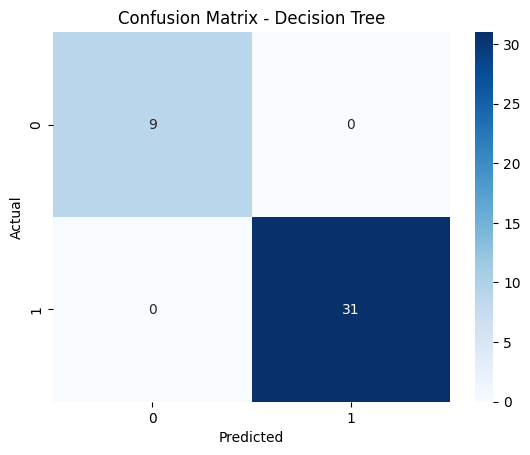

In [14]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()